In [1]:
# 4ч

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [4]:
import numpy as np

In [5]:
from sklearn.preprocessing import quantile_transform

In [6]:
balances_df = pd.read_csv("./data/ethereum_genesis_snapshot.csv")

In [7]:
balances_df = balances_df.sort_values("balance", ascending=False)

In [8]:
TOTAL_CYB = 11116463155970720 * 0.1 # ethereum drop amount
TOTAL_THRESHOLD = 0.8

In [9]:
MIN_CYB = 1000

In [10]:
def human_format(num):
    num = float('{:.3g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T', 'Q'][magnitude])

In [11]:
def get_description(group_name, balances_df):
    return "{}\n {} addresses \n {} CYB total\n {} CYB average\n {} CYB min".format(
        group_name, 
        human_format(balances_df[balances_df["cyb_balance"] >= MIN_CYB].shape[0]),
        human_format(balances_df["cyb_balance"].sum()), 
        human_format(balances_df["cyb_balance"].mean()),
        human_format(balances_df["cyb_balance"].min())
    )

In [12]:
def get_names(quantiles):
    return ["TOP-{}".format(human_format(q)) for q in quantiles]

In [13]:
def generate_piechart(balances_df, balance_field, total_threshold=TOTAL_THRESHOLD):
    balances_df["percentage"] = (balances_df[balance_field] / balances_df[balance_field].sum())
    balances_df["threshold"] = balances_df["percentage"].cumsum()
    balances_df = balances_df[balances_df["threshold"] <= total_threshold].copy()
    
    balances_df["percentage"] = (balances_df[balance_field] / balances_df[balance_field].sum())
    balances_df["cyb_balance"] = balances_df["percentage"] * TOTAL_CYB
    
    top_levels = np.array([1000, 10000, 100000, 500000, 1000000, 5000000]) / balances_df.shape[0]
    top_levels = np.minimum(top_levels, 1)

    quantiles = balances_df["threshold"].quantile(q=top_levels).to_frame()
    quantiles["name"] = get_names(top_levels * balances_df.shape[0])

    balances_df["level"] = ""
    for _, row in quantiles.sort_values("threshold", ascending=False).iterrows():
        selected_indices = balances_df["threshold"] < row["threshold"]
        balances_df.loc[selected_indices, "level"] = row["name"]

    unknown_indices = balances_df["level"] == ""
    balances_df.loc[unknown_indices, "level"] = "Other"

    balances_size = balances_df.groupby("level").size().sort_values()
    balances_size.plot(kind="pie", figsize=(10, 10), fontsize=10, colormap='Reds')
    
    legend = [get_description(name, balances_df[balances_df["level"] == name]) for name in balances_size.index]
    plt.legend(legend)
    
    plt.title(get_description("Total", balances_df), fontsize=20)
    plt.ylabel("")
    plt.xlabel("")

    my_circle=plt.Circle((0,0), 0.8, color='white')
    p=plt.gcf()
    p.gca().add_artist(my_circle)

# Вариант A (Без изменений)

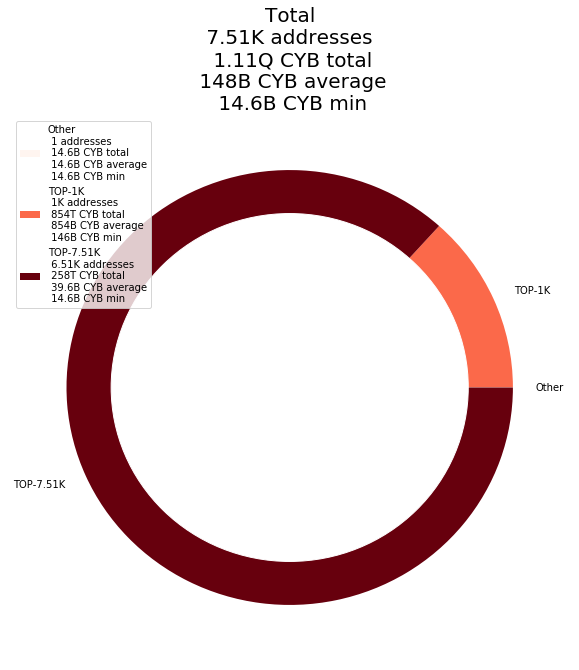

In [14]:
generate_piechart(balances_df, "balance")

# Вариант B (Квадратный корень)

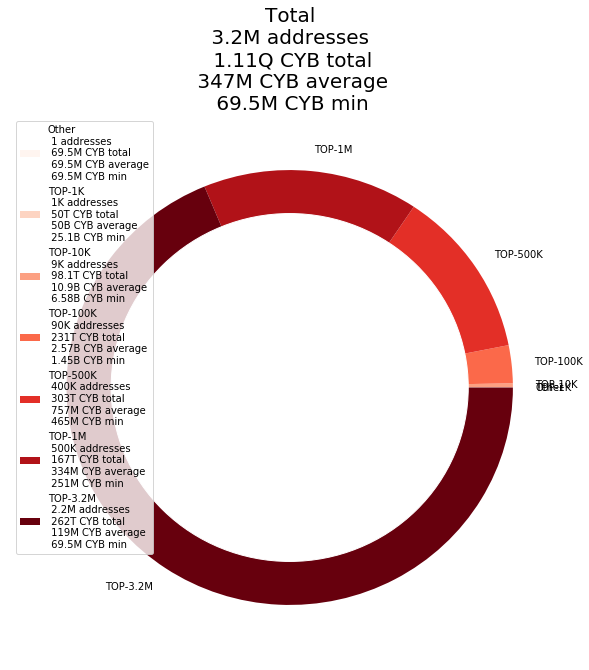

In [15]:
balances_df["sqrt_balance"] = balances_df["balance"].pow(0.5)
generate_piechart(balances_df, "sqrt_balance")

# Вариант C (Логарифм)

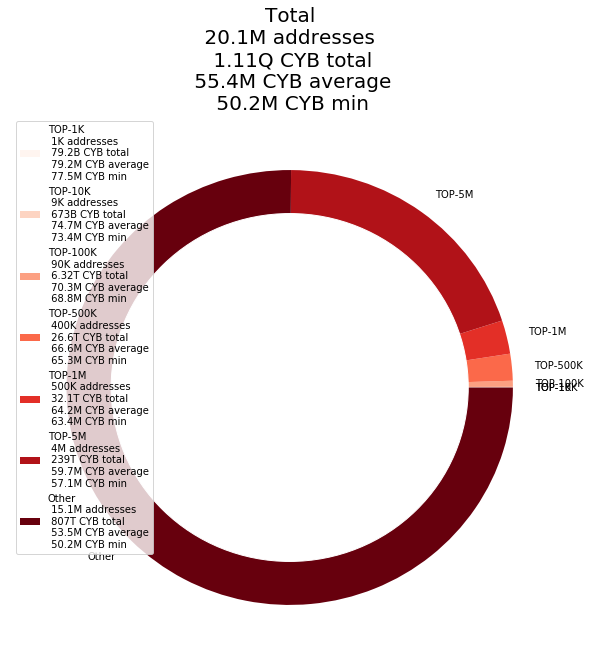

In [23]:
balances_df["log_balance"] = np.log(balances_df["balance"]) - np.log(balances_df["balance"]).min()
generate_piechart(balances_df, "log_balance")

# Вариант D (Квантильное преобразование)

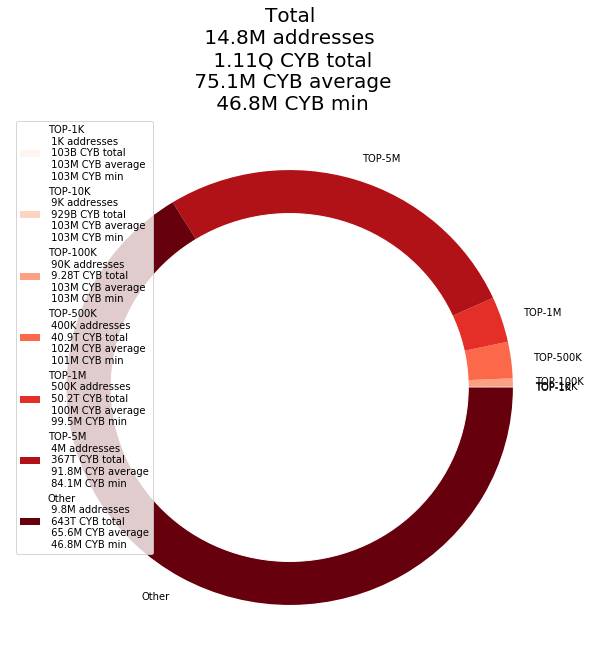

In [17]:
balances_df["qt_balance"] = quantile_transform(balances_df["balance"].values.reshape(-1, 1), copy=True).reshape(-1)
generate_piechart(balances_df, "qt_balance")